# Bayesian Network

<div class="list-group" id="list-tab" role="tablist">
  <h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Notebook Content</h3>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#Introduction" role="tab" aria-controls="profile">Introduction<span class="badge badge-primary badge-pill"></span></a>
  <a class="list-group-item list-group-item-action" data-toggle="list" href="#Bayesian-Structural-Time-Series(BSTS)-Model" role="tab" aria-controls="messages">Bayesian Time Series<span class="badge badge-primary badge-pill"></span></a>
  <a class="list-group-item list-group-item-action"  data-toggle="list" href="#Bayesian-Belief-Network" role="tab" aria-controls="settings">Bayesian Belief Network<span class="badge badge-primary badge-pill"></span></a>
    </div>

# Introduction

Bayesian networks are a type of probabilistic graphical model that uses Bayesian inference for probability computations. Bayesian networks aim to model conditional dependence, and therefore causation, by representing conditional dependence by edges in a directed graph. Through these relationships, one can efficiently conduct inference on the random variables in the graph through the use of factors.

Before we jump right into it, lets take a moment to discuss the basics of Bayesian theory and how it applies to regression. Ordinarily, If someone wanted to estimate a linear regression of the form:
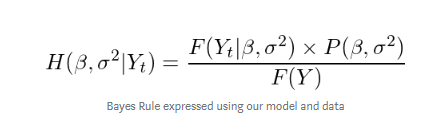

Let’s take a moment to think about why we would we even want to use Bayesian techniques in the first place. Well, there are a couple of advantages in doing so and these are particularly attractive for time series analysis. One issue when working with time series models is over-fitting particularly when estimating models with large numbers of parameters over relatively short time periods. This is not such a problem in this particular case but certainly can be when looking at multiple variables which is quite common in economic forecasting. One solution to the over-fitting problem, is to take a Bayesian approach which allows us to impose certain priors on our variables.

<a class="list-group-item list-group-item-action" data-toggle="list" href="#Bayesian-Network" role="tab" aria-controls="profile">Go to top<span class="badge badge-primary badge-pill"></span></a>

# Install Packages

In [1]:
install.packages('lubridate')
install.packages('bsts')
#install.packages('dplyr')
install.packages('ggplot2')
install.packages('forecast')
options(warn=-1)

package 'lubridate' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'lubridate'"Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\mohitkumar\Anaconda3\envs\lets_code\Lib\R\library\00LOCK\lubridate\libs\x64\lubridate.dll to C:\Users\mohitkumar\Anaconda3\envs\lets_code\Lib\R\library\lubridate\libs\x64\lubridate.dll: Permission denied"Warning message:
"restored 'lubridate'"


The downloaded binary packages are in
	C:\Users\mohitkumar\AppData\Local\Temp\RtmpcHHLdu\downloaded_packages


also installing the dependencies 'BoomSpikeSlab', 'Boom'



package 'BoomSpikeSlab' successfully unpacked and MD5 sums checked
package 'Boom' successfully unpacked and MD5 sums checked
package 'bsts' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\mohitkumar\AppData\Local\Temp\RtmpcHHLdu\downloaded_packages
package 'ggplot2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\mohitkumar\AppData\Local\Temp\RtmpcHHLdu\downloaded_packages


also installing the dependencies 'quadprog', 'fracdiff', 'tseries', 'urca'



package 'quadprog' successfully unpacked and MD5 sums checked
package 'fracdiff' successfully unpacked and MD5 sums checked
package 'tseries' successfully unpacked and MD5 sums checked
package 'urca' successfully unpacked and MD5 sums checked
package 'forecast' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\mohitkumar\AppData\Local\Temp\RtmpcHHLdu\downloaded_packages


# Airline Passenger Data
An ARIMA Model
First, let’s start by fitting a classical ARIMA (autoregressive integrated moving average) model to the famous airline passenger dataset. The ARIMA model has the following characteristics:

First order differencing (d=1) and a moving average term (q=1)
Seasonal differencing and a seasonal MA term
The year of 1960 was used as the holdout period for validation
Using a log transformation to model the growth rate


Attaching package: 'lubridate'

The following objects are masked from 'package:base':

    date, intersect, setdiff, union

Loading required package: BoomSpikeSlab
Loading required package: Boom
Loading required package: MASS

Attaching package: 'Boom'

The following object is masked from 'package:stats':

    rWishart


Attaching package: 'BoomSpikeSlab'

The following object is masked from 'package:stats':

    knots

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: xts
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: 'bsts'

The following object is masked from 'package:BoomSpikeSlab':

    SuggestBurn


Attaching package: 'dplyr'

The following objects are masked from 'package:xts':

    first, last

The following object is masked from 'package:MASS':

    select

The following objects are masked from 'package:stats

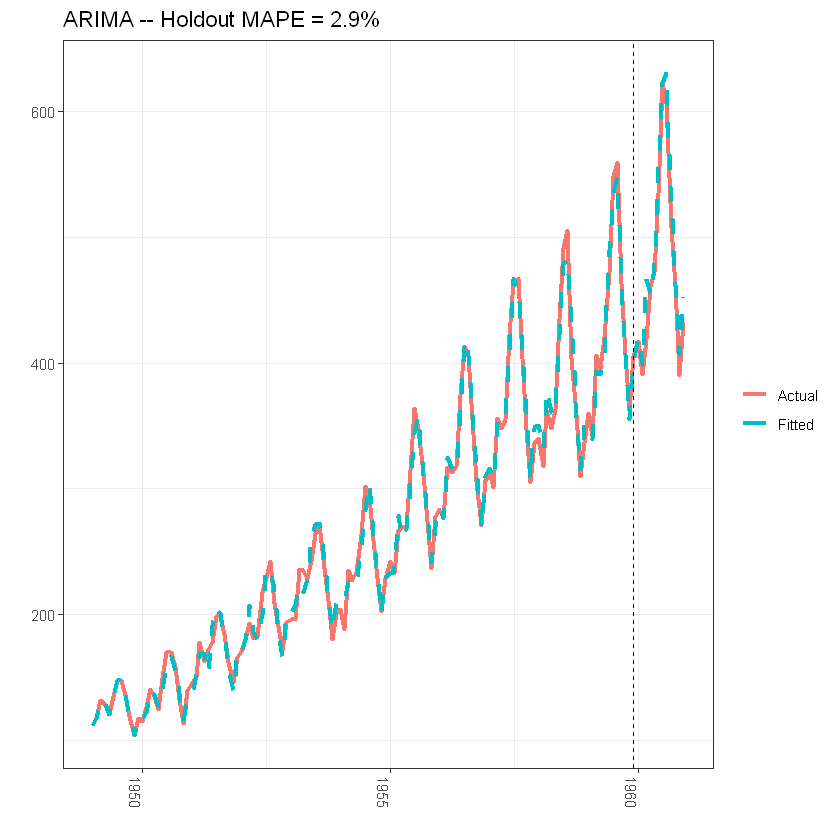

In [2]:
# https://multithreaded.stitchfix.com/blog/2016/04/21/forget-arima/
library(lubridate)
library(bsts)
library(dplyr)
library(ggplot2)
library(forecast)
options(warn=-1)

### Load the data
data("AirPassengers")
Y <- window(AirPassengers, start=c(1949, 1), end=c(1959,12))

### Fit the ARIMA model
arima <- arima(log10(Y), 
               order=c(0, 1, 1), 
               seasonal=list(order=c(0,1,1), period=12))

### Actual versus predicted
d1 <- data.frame(c(10^as.numeric(fitted(arima)), # fitted and predicted
                   10^as.numeric(predict(arima, n.ahead = 12)$pred)),
                   as.numeric(AirPassengers), #actual values
                   as.Date(time(AirPassengers)))
names(d1) <- c("Fitted", "Actual", "Date")


### MAPE (mean absolute percentage error)
MAPE <- filter(d1, year(Date)>1959) %>% summarise(MAPE=mean(abs(Actual-Fitted)/Actual))

### Plot actual versus predicted
ggplot(data=d1, aes(x=Date)) +
  geom_line(aes(y=Actual, colour = "Actual"), size=1.2) +
  geom_line(aes(y=Fitted, colour = "Fitted"), size=1.2, linetype=2) +
  theme_bw() + theme(legend.title = element_blank()) + 
  ylab("") + xlab("") +
  geom_vline(xintercept=as.numeric(as.Date("1959-12-01")), linetype=2) +
  ggtitle(paste0("ARIMA -- Holdout MAPE = ", round(100*MAPE,2), "%")) + 
  theme(axis.text.x=element_text(angle = -90, hjust = 0))


This model predicts the holdout period quite well as measured by the MAPE (mean absolute percentage error). However, the model does not tell us much about the time series itself. In other words, we cannot visualize the “story” of the model. All we know is that we can fit the data well using a combination of moving averages and lagged terms.

# Bayesian Structural Time Series(BSTS) Model
A different approach would be to use a Bayesian structural time series model with unobserved components. This technique is more transparent than ARIMA models and deals with uncertainty in a more elegant manner. It is more transparent because its representation does not rely on differencing, lags and moving averages. You can visually inspect the underlying components of the model. It handles uncertainty in a better way because you can quantify the posterior uncertainty of the individual components, control the variance of the components, and impose prior beliefs on the model. Last, but not least, any ARIMA model can be recast as a structural model.

Generally, we can write a Bayesian structural model like this:

Yt=μt+xtβ+St+et,et∼N(0,σ2e)

μt+1=μt+νt,νt∼N(0,σ2ν).

Here xt denotes a set of regressors, St represents seasonality, and μt is the local level term. The local level term defines how the latent state evolves over time and is often referred to as the unobserved trend. This could, for example, represent an underlying growth in the brand value of a company or external factors that are hard to pinpoint, but it can also soak up short term fluctuations that should be controlled for with explicit terms. Note that the regressor coefficients, seasonality and trend are estimated simultaneously, which helps avoid strange coefficient estimates due to spurious relationships (similar in spirit to Granger causality, see 1). In addition, due to the Bayesian nature of the model, we can shrink the elements of β to promote sparsity or specify outside priors for the means in case we’re not able to get meaningful estimates from the historical data (more on this later).

The airline passenger dataset does not have any regressors, and so we’ll fit a simple Bayesian structural model:

* 500 MCMC draws
* Use 1960 as the holdout period
* Trend and seasonality
* Forecast created by averaging across the MCMC draws
* Credible interval generated from the distribution of the MCMC draws
* Discarding the first MCMC iterations (burn-in)
* Using a log transformation to make the model multiplicative

### Components of BSTS

**add.local.linear.trend:** Local linear trend state component

Add a local linear trend model to a state specification. The local linear trend model assumes that both the mean and the slope of the trend follow random walks. The equation for the mean is

mu[t+1] = mu[t] + delta[t] + rnorm(1, 0, sigma.level).

The equation for the slope is

delta[t+1] = delta[t] + rnorm(1, 0, sigma.slope).

The prior distribution is on the level standard deviation sigma.level and the slope standard deviation sigma.slope.

Reference:https://rdrr.io/cran/bsts/man/add.local.linear.trend.html

**add.seasonal:** Seasonal State Component

Add a seasonal model to a state specification.

The seasonal model can be thought of as a regression on nseasons dummy variables with coefficients constrained to sum to 1 (in expectation). If there are S seasons then the state vector gamma is of dimension S-1. The first element of the state vector obeys

gamma[t+1, 1] = -1 * sum(gamma[t, -1]) + rnorm(1, 0, sigma)

Reference: https://rdrr.io/cran/bsts/man/add.seasonal.html


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Warning message:
"package 'bsts' was built under R version 3.6.3"Loading required package: BoomSpikeSlab
Warning message:
"package 'BoomSpikeSlab' was built under R version 3.6.3"Loading required package: Boom
Warning message:
"package 'Boom' was built under R version 3.6.3"Loading required package: MASS

Attaching package: 'Boom'

The following object is masked from 'package:stats':

    rWishart


Attaching package: 'BoomSpikeSlab'

The following object is masked from 'package:stats':

    knots

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: xts
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: 'bsts'

The following object is masked from 'package:BoomSpikeSlab':

    SuggestBurn

Warning message:
"package 'dplyr' was buil

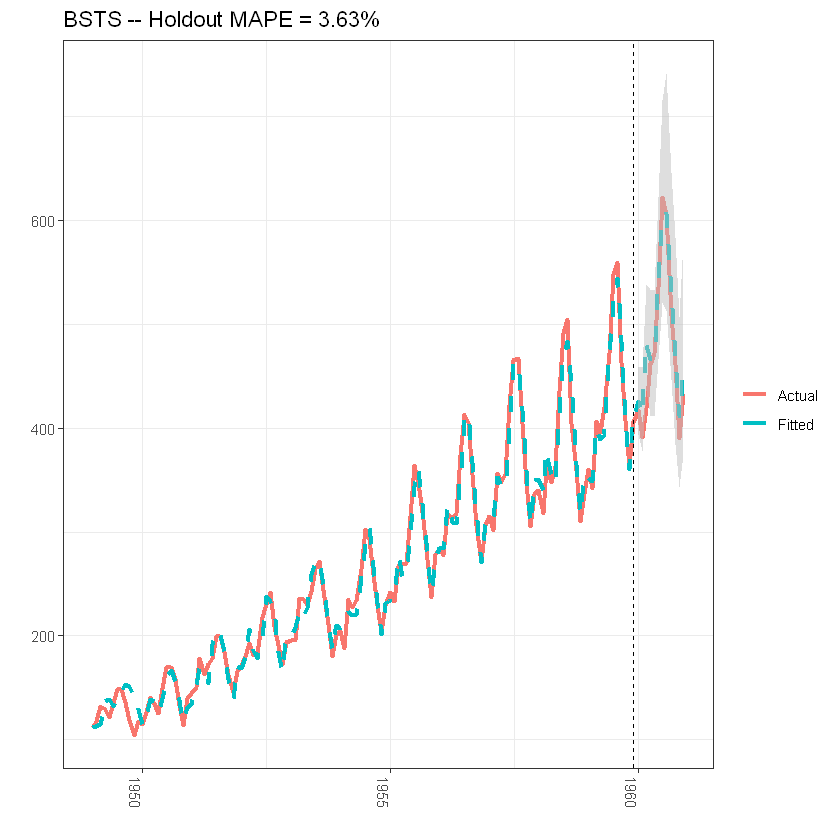

In [1]:
library(lubridate)
library(bsts)
library(dplyr)
library(ggplot2)

### Load the data
data("AirPassengers")
Y <- window(AirPassengers, start=c(1949, 1), end=c(1959,12))
y <- log10(Y)


### Run the bsts model
ss <- AddLocalLinearTrend(list(), y)
ss <- AddSeasonal(ss, y, nseasons = 12)
bsts.model <- bsts(y, state.specification = ss, niter = 500, ping=0, seed=2016)

### Get a suggested number of burn-ins
burn <- SuggestBurn(0.1, bsts.model)

### Predict
p <- predict.bsts(bsts.model, horizon = 12, burn = burn, quantiles = c(.025, .975))

### Actual versus predicted
d2 <- data.frame(
    # fitted values and predictions
    c(10^as.numeric(-colMeans(bsts.model$one.step.prediction.errors[-(1:burn),])+y),  
    10^as.numeric(p$mean)),
    # actual data and dates 
    as.numeric(AirPassengers),
    as.Date(time(AirPassengers)))
names(d2) <- c("Fitted", "Actual", "Date")

### MAPE (mean absolute percentage error)
MAPE <- filter(d2, year(Date)>1959) %>% summarise(MAPE=mean(abs(Actual-Fitted)/Actual))

### 95% forecast credible interval
posterior.interval <- cbind.data.frame(
  10^as.numeric(p$interval[1,]),
  10^as.numeric(p$interval[2,]), 
  subset(d2, year(Date)>1959)$Date)
names(posterior.interval) <- c("LL", "UL", "Date")

### Join intervals to the forecast
d3 <- left_join(d2, posterior.interval, by="Date")

### Plot actual versus predicted with credible intervals for the holdout period
ggplot(data=d3, aes(x=Date)) +
  geom_line(aes(y=Actual, colour = "Actual"), size=1.2) +
  geom_line(aes(y=Fitted, colour = "Fitted"), size=1.2, linetype=2) +
  theme_bw() + theme(legend.title = element_blank()) + ylab("") + xlab("") +
  geom_vline(xintercept=as.numeric(as.Date("1959-12-01")), linetype=2) + 
  geom_ribbon(aes(ymin=LL, ymax=UL), fill="grey", alpha=0.5) +
  ggtitle(paste0("BSTS -- Holdout MAPE = ", round(100*MAPE,2), "%")) +
  theme(axis.text.x=element_text(angle = -90, hjust = 0))

## Side Notes on the bsts Examples in this Post
* When building Bayesian models we get a distribution and not a single answer. Thus, the bsts package returns results (e.g., forecasts and components) as matrices or arrays where the first dimension holds the MCMC iterations.
* Most of the plots in this post show point estimates from averaging (using the colMeans function). But it’s very easy to get distributions from the MCMC draws, and this is recommended in real life to better quantify uncertainty.
* For visualization, I went with ggplot for this example in order to demonstrate how to retrieve the output for custom plotting. Alternatively, we can simply use the plot.bsts function that comes with the bsts package.

Note that the predict.bsts function automatically supplies the upper and lower limits for a credible interval (95% in our case). We can also access the distribution for all MCMC draws by grabbing the distribution matrix (instead of interval). Each row in this matrix is one MCMC draw. Here’s an example of how to calculate percentiles from the posterior distribution:

In [4]:
credible.interval <- cbind.data.frame(
  10^as.numeric(apply(p$distribution, 2,function(f){quantile(f,0.75)})),
  10^as.numeric(apply(p$distribution, 2,function(f){median(f)})),
  10^as.numeric(apply(p$distribution, 2,function(f){quantile(f,0.25)})),
  subset(d3, year(Date)>1959)$Date)
names(credible.interval) <- c("p75", "Median", "p25", "Date")

Although the holdout MAPE (mean absolute percentage error) is larger than the ARIMA model for this specific dataset (and default settings), the bsts model does a great job of capturing the growth and seasonality of the air passengers time series. Moreover, one of the big advantages of the Bayesian structural model is that we can visualize the underlying components. In this example, we’re using ggplot to plot the average of the MCMC draws for the trend and the seasonal components:

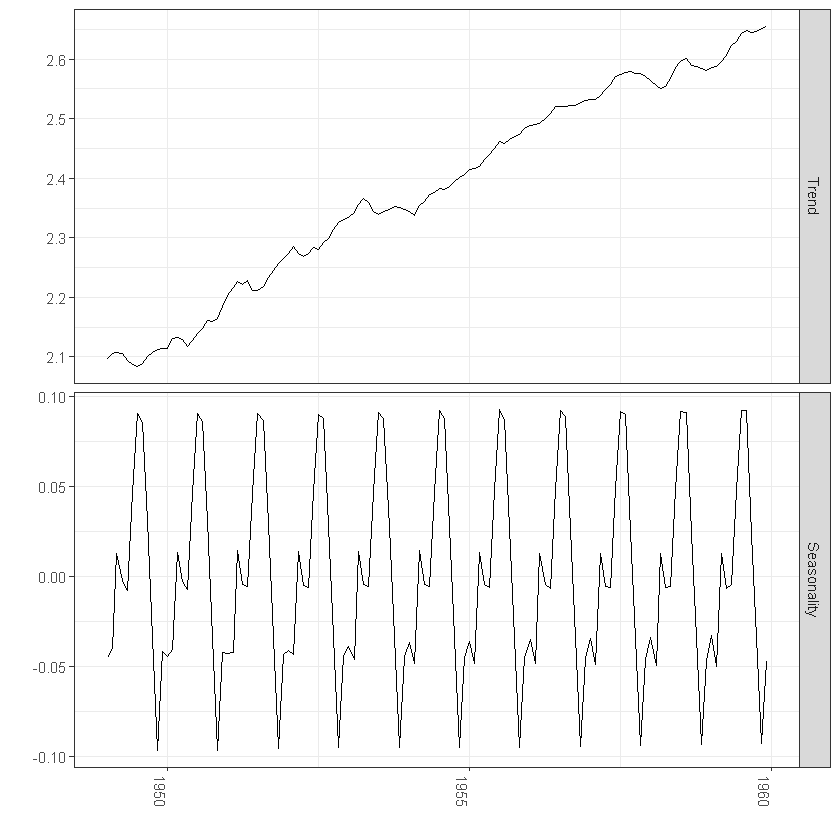

In [5]:
library(lubridate)
library(bsts)
library(ggplot2)
library(reshape2)

### Set up the model
data("AirPassengers")
Y <- window(AirPassengers, start=c(1949, 1), end=c(1959,12))
y <- log10(Y)
ss <- AddLocalLinearTrend(list(), y)
ss <- AddSeasonal(ss, y, nseasons = 12)
bsts.model <- bsts(y, state.specification = ss, niter = 500, ping=0, seed=2016)

### Get a suggested number of burn-ins
burn <- SuggestBurn(0.1, bsts.model)

### Extract the components
components <- cbind.data.frame(
  colMeans(bsts.model$state.contributions[-(1:burn),"trend",]),                               
  colMeans(bsts.model$state.contributions[-(1:burn),"seasonal.12.1",]),
  as.Date(time(Y)))  
names(components) <- c("Trend", "Seasonality", "Date")
components <- melt(components, id="Date")
names(components) <- c("Date", "Component", "Value")

### Plot
ggplot(data=components, aes(x=Date, y=Value)) + geom_line() + 
  theme_bw() + theme(legend.title = element_blank()) + ylab("") + xlab("") + 
  facet_grid(Component ~ ., scales="free") + guides(colour=FALSE) + 
  theme(axis.text.x=element_text(angle = -90, hjust = 0))

Here we can clearly the seasonal pattern of airline passengers as well as how the airline industry grew during this period.

# Bayesian Variable Selection
Another advantage of Bayesian structural models is the ability to use spike-and-slab priors. This provides a powerful way of reducing a large set of correlated variables into a parsimonious model, while also imposing prior beliefs on the model. Furthermore, by using priors on the regressor coefficients, the model incorporates uncertainties of the coefficient estimates when producing the credible interval for the forecasts.

As the name suggests, spike and slab priors consist of two parts: the spike part and the slab part. The spike part governs the probability of a given variable being chosen for the model (i.e., having a non-zero coefficient). The slab part shrinks the non-zero coefficients toward prior expectations (often zero). To see how this works, let τ denote a vector of 1s and 0s where a value of 1 indicates that the variable is selected (non-zero coefficient). We can factorize the spike and slab prior as follows (see 1) :

p(τ,β,1/σ2ϵ)=p(τ)p(σ2ϵ | τ)p(β | τ,σ2ϵ)

The probability of choosing a given variable is typically assumed to follow a Bernoulli distribution where the parameter can be set according to the expected model size. For example, if the expected model size is 5 and we have 50 potential variables, we could set all spike parameters equal to 0.1. Alternatively, we can also set individual spike parameters to 0 or 1 to force certain variables in or out of the model.

For the slab part, a normal prior is used for β which leads to an inverse Gamma prior for σ2ϵ. The mean is specified through the prior expectations for β (zero by default). The tightness of the priors can be expressed in terms of observations worth of weight (demonstrated later). For more technical information see 1 .

# Using Spike and Slab Priors for the Initial Claims Data
Here’s an example of fitting a model to the initial claims data, which is a weekly time series of US initial claims for unemployment (the first column is the dependent variable, which contains the initial claims numbers from FRED). The model has a trend component, a seasonal component, and a regression component.

For model selection, we are essentially using the “spike” part of the algorithm to select variables and the “slab” part to shrink the coefficients towards zero (akin to ridge regression).


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Loading required package: BoomSpikeSlab
Loading required package: Boom
Loading required package: MASS

Attaching package: 'Boom'

The following object is masked from 'package:stats':

    rWishart


Attaching package: 'BoomSpikeSlab'

The following object is masked from 'package:stats':

    knots

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: xts
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: 'bsts'

The following object is masked from 'package:BoomSpikeSlab':

    SuggestBurn



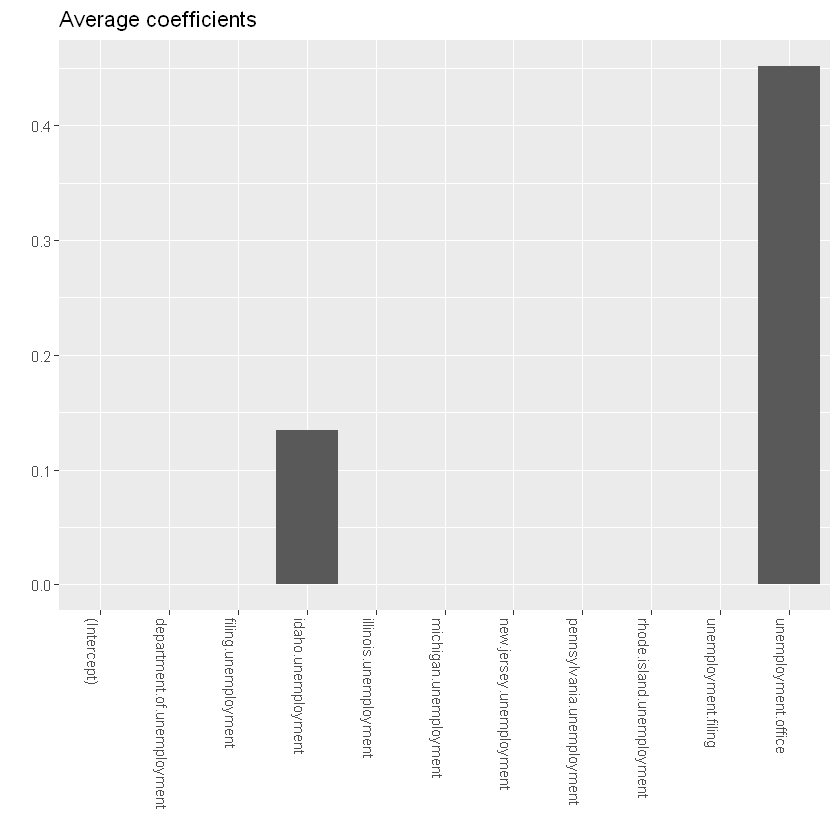

In [2]:
library(lubridate)
library(bsts)
library(ggplot2)
library(reshape2)

### Fit the model with regressors
data(iclaims)
## Description of data set can be accessed by using Shift + Tab
ss <- AddLocalLinearTrend(list(), initial.claims$iclaimsNSA)
ss <- AddSeasonal(ss, initial.claims$iclaimsNSA, nseasons = 52)
bsts.reg <- bsts(iclaimsNSA ~ ., state.specification = ss, data =
                initial.claims, niter = 500, ping=0, seed=2016)

### Get the number of burn-ins to discard
burn <- SuggestBurn(0.1, bsts.reg)

### Helper function to get the positive mean of a vector
PositiveMean <- function(b) {
  b <- b[abs(b) > 0]
  if (length(b) > 0) 
    return(mean(b))
  return(0)
}

### Get the average coefficients when variables were selected (non-zero slopes)
coeff <- data.frame(melt(apply(bsts.reg$coefficients[-(1:burn),], 2, PositiveMean)))
coeff$Variable <- as.character(row.names(coeff))
ggplot(data=coeff, aes(x=Variable, y=value)) + 
  geom_bar(stat="identity", position="identity") + 
  theme(axis.text.x=element_text(angle = -90, hjust = 0)) +
  xlab("") + ylab("") + ggtitle("Average coefficients")

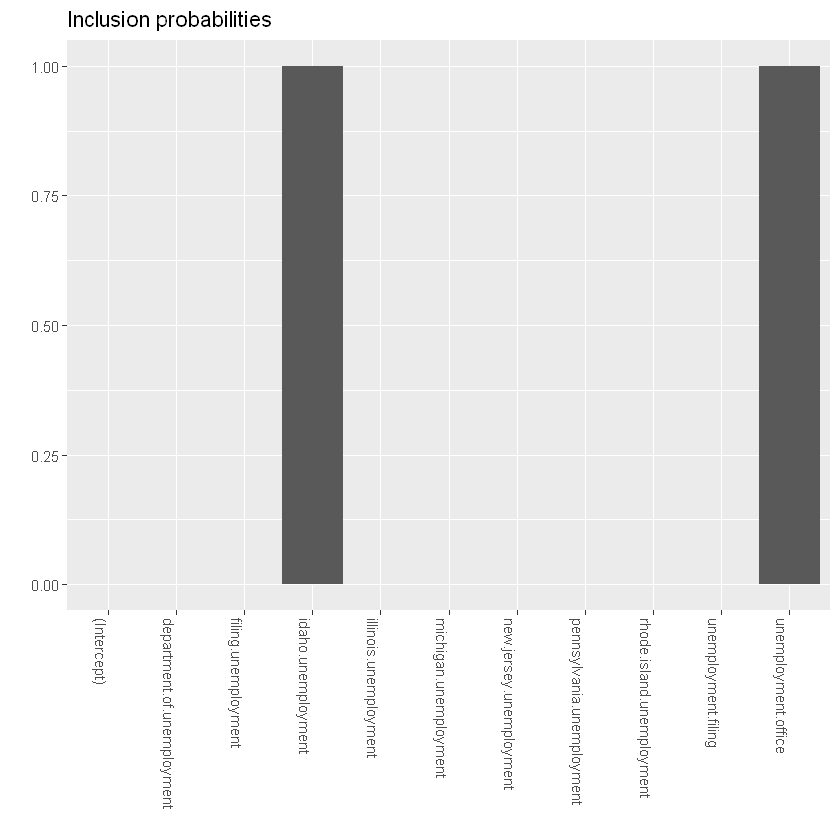

In [7]:
### Inclusion probabilities -- i.e., how often were the variables selected 
inclusionprobs <- melt(colMeans(bsts.reg$coefficients[-(1:burn),] != 0))
inclusionprobs$Variable <- as.character(row.names(inclusionprobs))
ggplot(data=inclusionprobs, aes(x=Variable, y=value)) + 
  geom_bar(stat="identity", position="identity") + 
  theme(axis.text.x=element_text(angle = -90, hjust = 0)) + 
  xlab("") + ylab("") + ggtitle("Inclusion probabilities")

The output shows that the model is dominated by two variables: unemployment.office and idaho.unemployment. These variables have the largest average coefficients and were selected in 100% of models. Note that if we want to inspect the distributions of the coefficients, we can can simply calculate quantiles instead of the mean inside the helper function above:

In [8]:
P75 <- function(b) {
  b <- b[abs(b) > 0]
  if (length(b) > 0) 
    return(quantile(b, 0.75))
  return(0)
}

p75 <- data.frame(melt(apply(bsts.reg$coefficients[-(1:burn),], 2, P75)))

And we can easily visualize the overall contribution of these variables to the model:

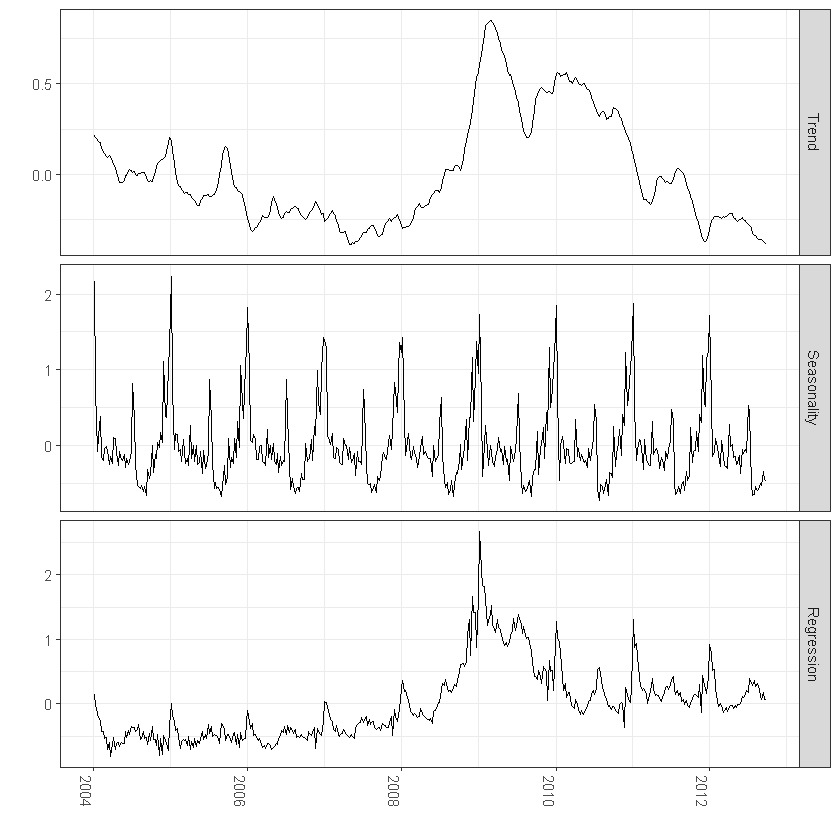

In [9]:
library(lubridate)
library(bsts)
library(ggplot2)
library(reshape2)

### Fit the model with regressors
data(iclaims)
## Description of data set can be accessed by using Shift + Tab
ss <- AddLocalLinearTrend(list(), initial.claims$iclaimsNSA)
ss <- AddSeasonal(ss, initial.claims$iclaimsNSA, nseasons = 52)
bsts.reg <- bsts(iclaimsNSA ~ ., state.specification = ss, data =
                initial.claims, niter = 500, ping=0, seed=2016)

### Get the number of burn-ins to discard
burn <- SuggestBurn(0.1, bsts.reg)

### Get the components
components.withreg <- cbind.data.frame(
  colMeans(bsts.reg$state.contributions[-(1:burn),"trend",]),
  colMeans(bsts.reg$state.contributions[-(1:burn),"seasonal.52.1",]),
  colMeans(bsts.reg$state.contributions[-(1:burn),"regression",]),
  as.Date(time(initial.claims)))  
names(components.withreg) <- c("Trend", "Seasonality", "Regression", "Date")
components.withreg <- melt(components.withreg, id.vars="Date")
names(components.withreg) <- c("Date", "Component", "Value")

ggplot(data=components.withreg, aes(x=Date, y=Value)) + geom_line() + 
  theme_bw() + theme(legend.title = element_blank()) + ylab("") + xlab("") + 
  facet_grid(Component ~ ., scales="free") + guides(colour=FALSE) + 
  theme(axis.text.x=element_text(angle = -90, hjust = 0))

In [1]:
??AddSeasonal

starting httpd help server ... done


# Including Prior Expectations in the Model
In the example above, we used the spike-and-slab prior as a way to select variables and promote sparsity. However, we can also use this framework to impose prior beliefs on the model. These prior beliefs could come from an outside study or a previous version of the model. This is a common use-case in time series regression; we cannot always rely on the data at hand to tell you how known business drivers affect the outcome.

In the bsts package, this is done by passing a prior object as created by the SpikeSlabPrior function. In this example we are specifying a prior of 0.6 on the variable called unemployment.office and forcing this variable to be selected by setting its prior spike parameter to 1. We’re giving our priors a weight of 200 (measured in observation count), which is fairly large given that the dataset has 456 records. Hence we should expect the posterior to be very close to 0.6.

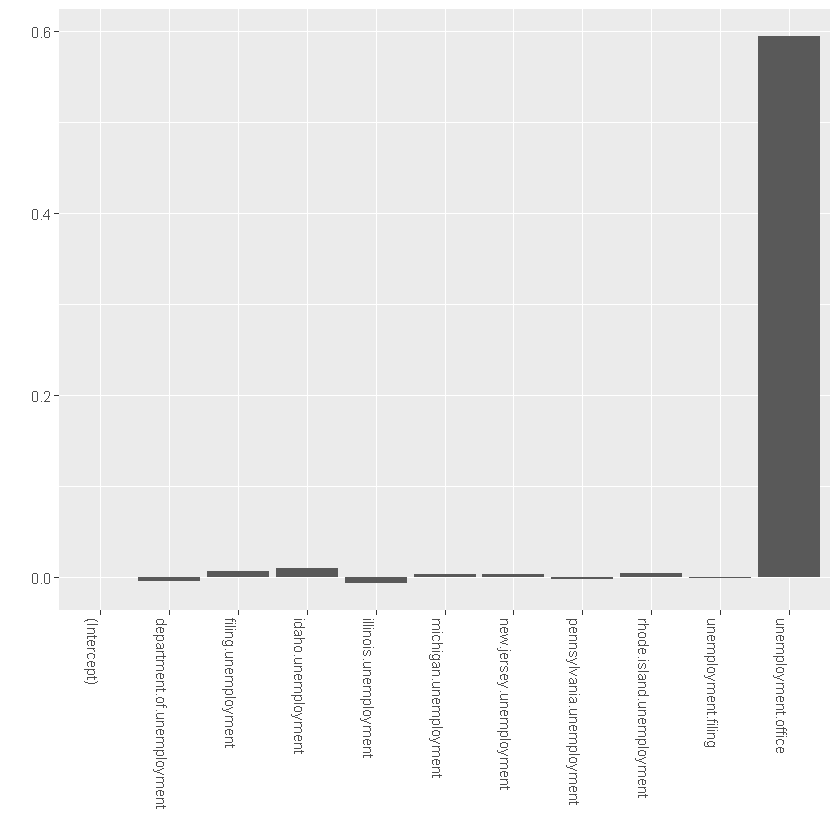

In [10]:
library(lubridate)
library(bsts)
library(ggplot2)
library(reshape2)

data(iclaims)
## Description of data set can be accessed by using Shift + Tab
prior.spikes <- c(0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,1,0.1)
prior.mean <- c(0,0,0,0,0,0,0,0,0,0.6,0)

### Helper function to get the positive mean of a vector
PositiveMean <- function(b) {
  b <- b[abs(b) > 0]
  if (length(b) > 0) 
    return(mean(b))
  return(0)
}

### Set up the priors
prior <- SpikeSlabPrior(x=model.matrix(iclaimsNSA ~ ., data=initial.claims), 
                        y=initial.claims$iclaimsNSA, 
                        prior.information.weight = 200,
                        prior.inclusion.probabilities = prior.spikes,
                        optional.coefficient.estimate = prior.mean)
                        
### Run the bsts model with the specified priors
data(iclaims)
ss <- AddLocalLinearTrend(list(), initial.claims$iclaimsNSA)
ss <- AddSeasonal(ss, initial.claims$iclaimsNSA, nseasons = 52)
bsts.reg.priors <- bsts(iclaimsNSA ~ ., state.specification = ss, 
                        data = initial.claims, 
                        niter = 500, 
                        prior=prior, 
                        ping=0, seed=2016)


### Get the average coefficients when variables were selected (non-zero slopes)
coeff <- data.frame(melt(apply(bsts.reg.priors$coefficients[-(1:burn),], 2, PositiveMean)))
coeff$Variable <- as.character(row.names(coeff))
ggplot(data=coeff, aes(x=Variable, y=value)) + 
  geom_bar(stat="identity", position="identity") + 
  theme(axis.text.x=element_text(angle = -90, hjust = 0)) + 
  xlab("") + ylab("")

As we can see, the posterior for unemployment.office is being forced towards 0.6 due to the strong prior belief that we imposed on the coefficient.

# Last Words
Bayesian structural time series models possess three key features for modeling time series data:

* Ability to incorporate uncertainty into our forecasts so we quantify future risk
* Transparency, so we can truly understand how the model works
* Ability to incorporate outside information for known business drivers when we cannot extract the relationships from the data at hand

Having said that, there is no silver bullet when it comes to forecasting and scenario planning. No tool or method can remove the embedded uncertainty or extract clear signals from murky or limited data. Bayesian structural modeling merely maximizes your chances of success.

<a class="list-group-item list-group-item-action" data-toggle="list" href="#Bayesian-Network" role="tab" aria-controls="profile">Go to top<span class="badge badge-primary badge-pill"></span></a>

# Bayesian Belief Network

#### Mathematical Definition of Belief Networks

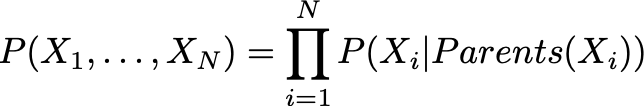

Bayesian networks (BNs) are a type of graphical model that encode the conditional probability between different learning variables in a directed acyclic graph. There are benefits to using BNs compared to other unsupervised machine learning techniques. A few of these benefits are:
1. It is easy to exploit expert knowledge in BN models. 
2. BN models have been found to be very robust in the sense of i) noisy data, ii) missing data and iii) sparse data. 
3. Unlike many machine learning models (including Artificial Neural Network), which usually appear as a “black box,” all the parameters in BNs have an understandable semantic interpretation. 

# Problem Statement

To understand the interdependence relation of each of the factors in a dataset which keeps on changing on the value of evidences.

In [1]:
# importing the libraries
library(bnlearn)

Warning message:
"package 'bnlearn' was built under R version 3.6.3"

In [2]:
# importing dataset
data(coronary)

This data contains the following information:

**Smoking (smoking):** a two-level factor with levels no and yes.                                                        
**M. Work (strenuous mental work):** a two-level factor with levels no and yes.                               
**P. Work (strenuous physical work):** a two-level factor with levels no and yes.                                 
**Pressure (systolic blood pressure):** a two-level factor with levels <140 and >140.                               
**Proteins (ratio of beta and alpha lipoproteins):** a two-level factor with levels.                             
**Family (family anamnesis of coronary heart disease):** a two-level factor with levels neg and pos.

In [3]:
head(coronary)

Smoking,M. Work,P. Work,Pressure,Proteins,Family
no,no,no,<140,<3,neg
no,no,no,<140,<3,neg
no,no,no,<140,<3,neg
no,no,no,<140,<3,neg
no,no,no,<140,<3,neg
no,no,no,<140,<3,neg


The first step in a BN is to create the network. There are couples of algorithms in deriving an optimal BN structure and some of them exist in “bnlearn”.

The above structure finding creates the following conditional dependency between different variables, and the plot function draws the BN as shown below:

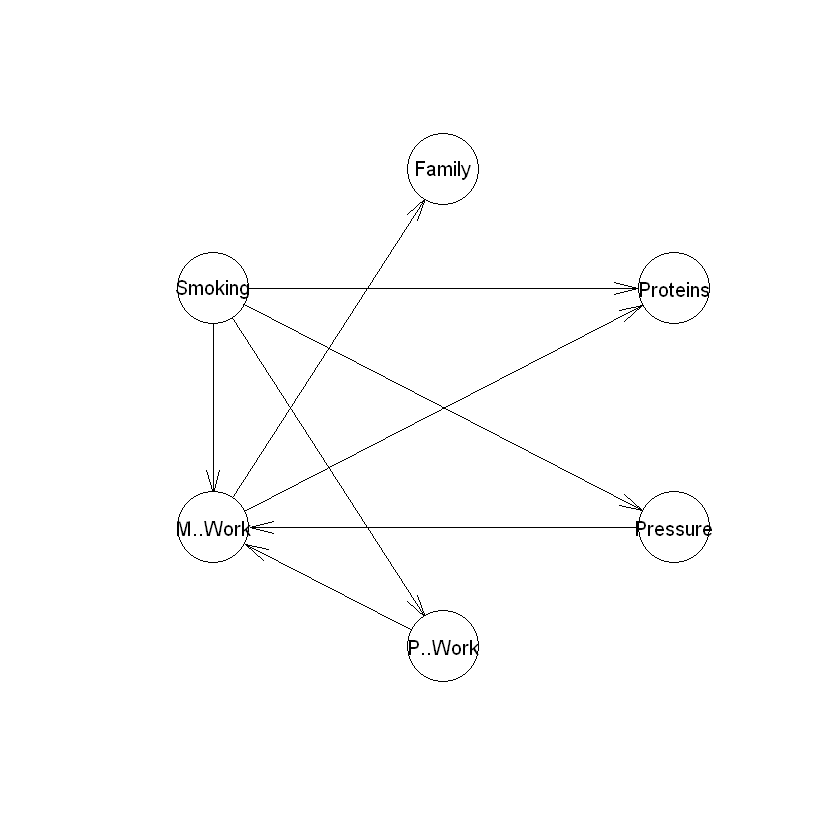

In [4]:
bn_df <- data.frame(coronary)
res <- hc(bn_df)
plot(res)

The causality between some nodes is intuitive; however, some relations extracted from data does not seem to be correct. For example, it does not make sense to have Family as a variable condition on M.Work. Therefore, we need to modify the derived structure. Let’s remove the link between M.Work and Family.

In [5]:
res$arcs <- res$arcs[-which((res$arcs[,'from'] == "M..Work" & res$arcs[,'to'] == "Family")),]

After learning the structure, we need to find out the conditional probability tables (CPTs) at each node. The bn.fit function runs the EM algorithm to learn CPT for different nodes in the above graph.

In [6]:
fittedbn <- bn.fit(res, data = bn_df)

For example, let look at what is inside the Protein node.

In [7]:
print(fittedbn$Proteins)


  Parameters of node Proteins (multinomial distribution)

Conditional probability table:
 
, , M..Work = no

        Smoking
Proteins        no       yes
      <3 0.6685824 0.6167763
      >3 0.3314176 0.3832237

, , M..Work = yes

        Smoking
Proteins        no       yes
      <3 0.5671982 0.3235294
      >3 0.4328018 0.6764706



## Inference

Now, the BN is ready and we can start inferring from the network.

In [8]:
cpquery(fittedbn, event = (Proteins=="<3"), evidence = ( Smoking=="no"))

[1] 0.6279693

which results in 0.61. Note that although the Proteins variable is conditioned on 2 variables, we did the query based on the available evidence on only one variables. But let make our evidence richer by asking the following: What is the chance that a non-smoker with pressure greater than 140 has a Proteins level less than 3?

In [11]:
cpquery(fittedbn, event = (Proteins=="<3"), evidence = ( Smoking=="no" & Pressure==">140" ))

[1] 0.6282764

which results in probability 0.63. 

We can also move in the opposite direction of an arc between two nodes. Let’s see if a person’s Proteins level is greater than 3, then what is the chance that his or her Pressure level is greater than 140?


In [12]:
cpquery(fittedbn, event = (Pressure==">140"), evidence = ( Proteins=="<3" ))

[1] 0.4213092

the answer would be Pressure is greater than 140 with probability 0.41

https://www.bnlearn.com/about/teaching/slides-bnshort.pdf

## Understanding the model architecture for Alarm-Burglar Problem

Bnlearn provides two S3 classes for Bayesian networks:
* "bn": the underlying DAG
* "bn.fit": a fully specified network with parameters

A compact way to specify a "bn" is the model string:

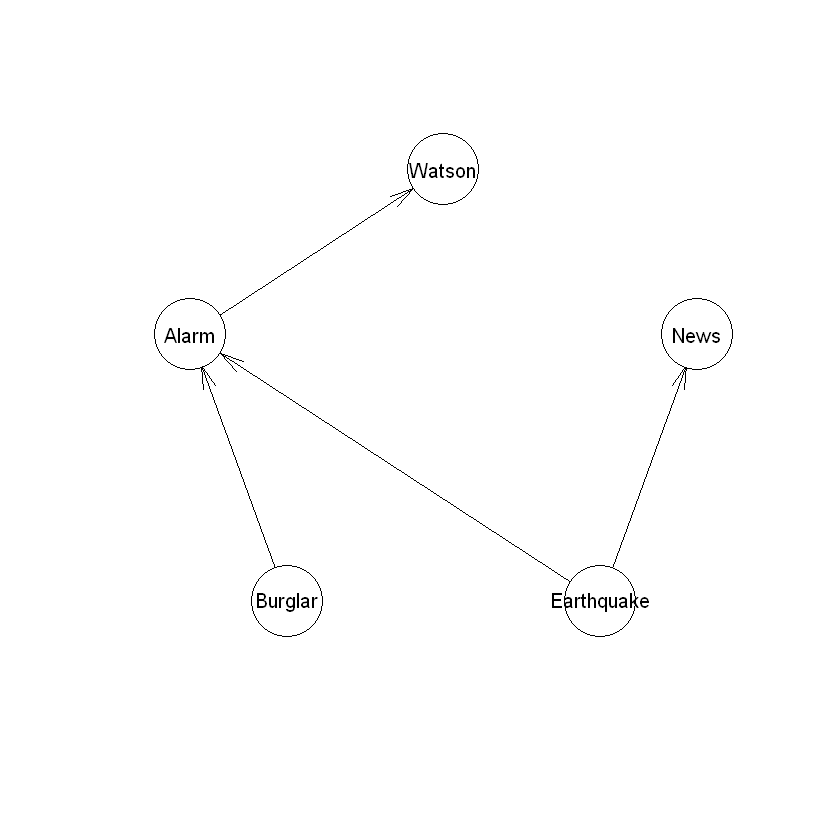

In [14]:
bl.alarm <- model2network('[Burglar][Earthquake][Alarm|Burglar:Earthquake][News|Earthquake][Watson|Alarm]')
plot(bl.alarm)

We can add, remove or reverse arcs, with the acyclic constraint enforced:

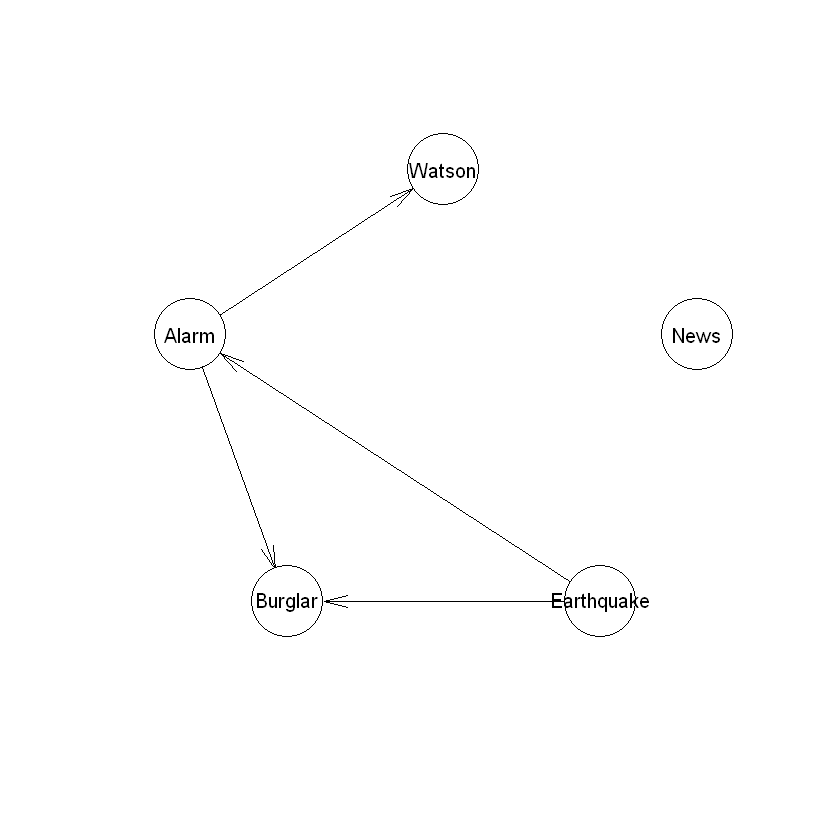

In [15]:
modified.alarm <- drop.arc(bl.alarm, "Earthquake", "News")
modified.alarm <- reverse.arc(modified.alarm , "Alarm", "Burglar")
modified.alarm <- set.arc(modified.alarm, "Earthquake", "Burglar")
plot(modified.alarm)

Printing the object to console provides basics information:

In [17]:
bl.alarm


  Random/Generated Bayesian network

  model:
   [Burglar][Earthquake][Alarm|Burglar:Earthquake][News|Earthquake][Watson|Alarm] 
  nodes:                                 5 
  arcs:                                  4 
    undirected arcs:                     0 
    directed arcs:                       4 
  average markov blanket size:           2.00 
  average neighbourhood size:            1.60 
  average branching factor:              0.80 

  generation algorithm:                  Empty 


When the network is too large for plotting, the model string can be useful. We can also ask about the nodes
close to a particular node:

In [20]:
nbr(bl.alarm, node = 'Alarm')

[1] "Burglar"    "Earthquake" "Watson"

In [21]:
parents(bl.alarm, node = 'Alarm')

[1] "Burglar"    "Earthquake"

In [22]:
children(bl.alarm, node = 'Alarm')

[1] "Watson"

In [23]:
mb(bl.alarm, node = 'Alarm')

[1] "Burglar"    "Earthquake" "Watson"

We can somewhat customize the network plot directly

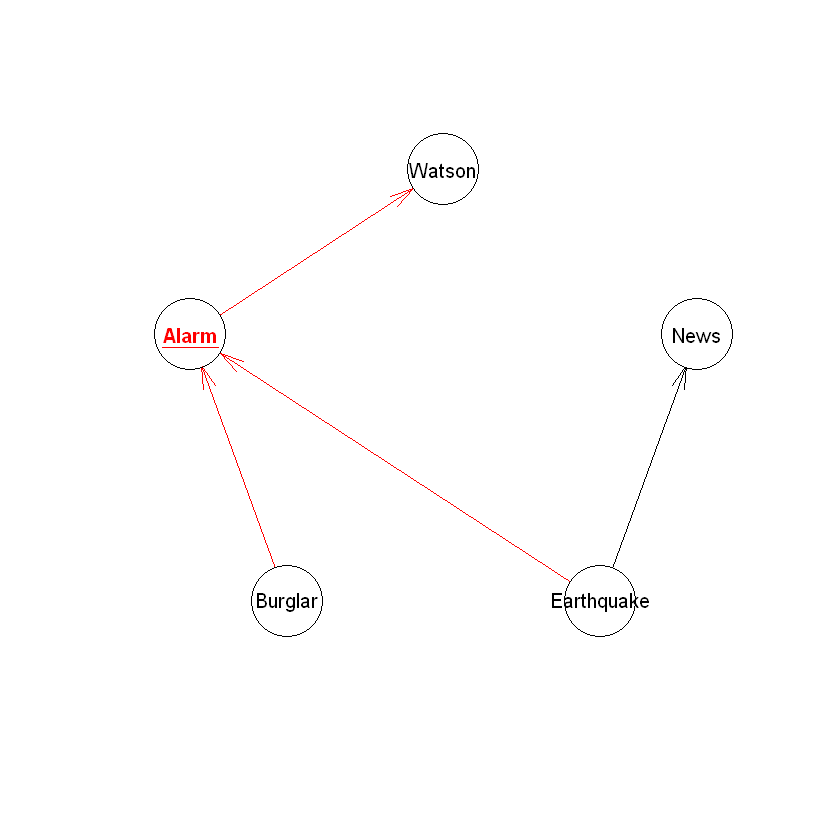

In [24]:
plot(bl.alarm, highlight = list(nodes='Alarm'))

We can list all arcs or ask for a path between a pair of nodes:

In [26]:
arcs(bl.alarm)

from,to
Burglar,Alarm
Earthquake,Alarm
Earthquake,News
Alarm,Watson


In [27]:
path(bl.alarm, from = "Burglar", to = "Watson")

[1] TRUE

In [28]:
path(bl.alarm, from = "Watson", to = "Burglar")

[1] FALSE

We can check for d-separation or obtain the CPDAG:

In [31]:
dsep(bl.alarm, 'Watson', 'News')

[1] FALSE

In [32]:
dsep(bl.alarm, 'Watson', 'News', 'Alarm')

[1] TRUE

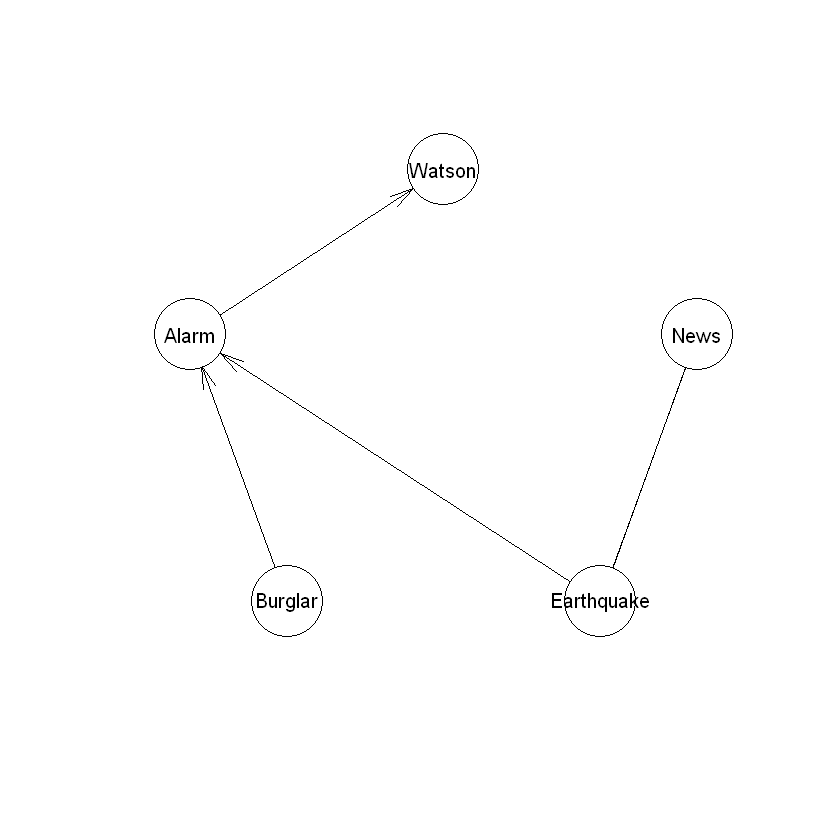

In [33]:
plot(cpdag(bl.alarm))

Passing a list of local distributions to custom.fit() produces a "bn.fit". With discrete variables, we can
specify a CPT for each node:

In [34]:
yn <- c("yes","no")
B <- array(dimnames = list(Burglar = yn), dim = 2, c(0.30,0.70))
E <- array(dimnames = list(Earthquake = yn), dim = 2, c(0.35,0.65))
A <- array(dimnames = list(Alarm = yn, Earthquake = yn, Burglar = yn), dim = c(2, 2, 2),
c(0.95,0.05,0.90,0.10,0.60,0.40,0.01,0.99))
W <- array(dimnames = list(Watson = yn, Alarm = yn), dim = c(2, 2), c(0.80,0.20,0.40,0.60))
N <- array(dimnames = list(News = yn, Earthquake = yn), dim = c(2, 2), c(0.60,0.40,0.01,0.99))
cpts <- list(Burglar = B, Earthquake = E, Alarm = A, Watson = W, News = N)
bl.alarm.fit = custom.fit(bl.alarm, cpts)

In [35]:
bl.alarm.fit$Earthquake


  Parameters of node Earthquake (multinomial distribution)

Conditional probability table:
 Earthquake
 yes   no 
0.35 0.65 

Loading required namespace: lattice


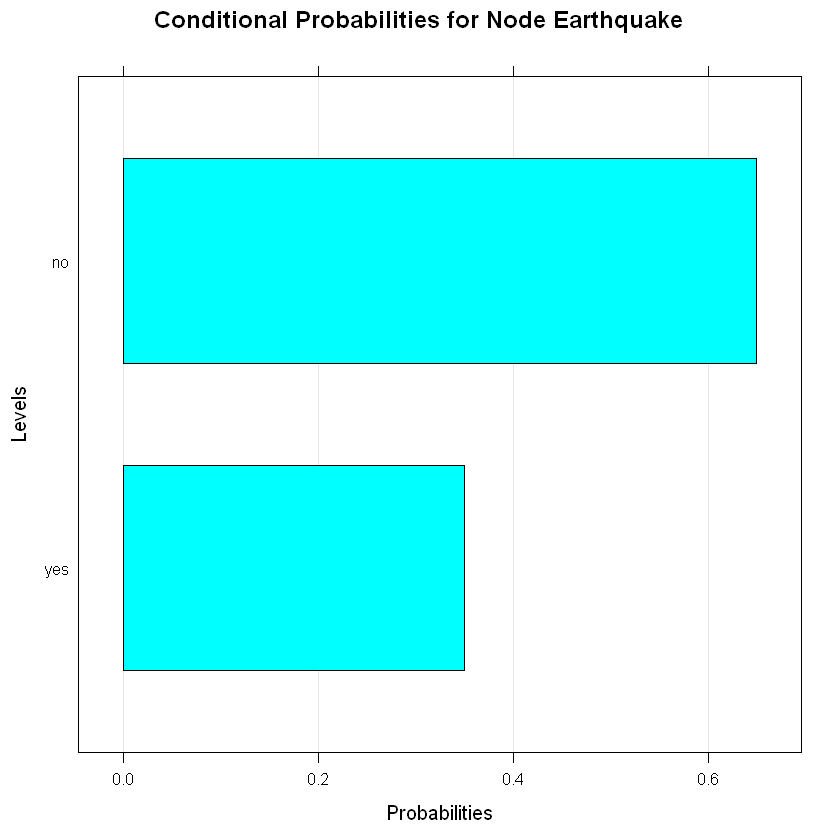

In [36]:
bn.fit.barchart(bl.alarm.fit$Earthquake)

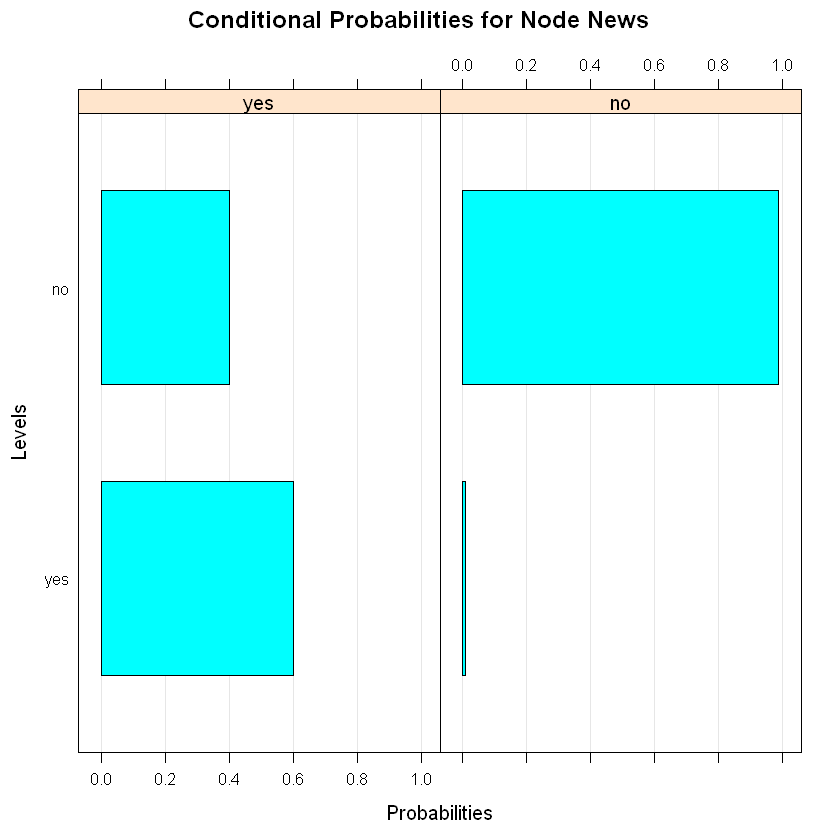

In [37]:
bn.fit.barchart(bl.alarm.fit$News)

<a class="list-group-item list-group-item-action" data-toggle="list" href="#Bayesian-Network" role="tab" aria-controls="profile">Go to top<span class="badge badge-primary badge-pill"></span></a>

# Conclusion

Bayesian belief networks is a class of highly data efficient and interpretable models for domains with causal relationships between variables. The tradeoff is a dependency on good prior knowledge and often problem-specific adaptions and simplifications.